In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline 

# 1 Loading data

## 1.1 Clinical Evidence

In [3]:
train_text_df = pd.read_csv('../datasets/training_text/training_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
submission_text_df = pd.read_csv('../datasets/test_text/test_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])

In [4]:
print('Number of Clinical Evidence for training samples', train_text_df.shape)
print('Number of Clinical Evidence for submission samples', submission_text_df.shape)

Number of Clinical Evidence for training samples (3321, 2)
Number of Clinical Evidence for submission samples (5668, 2)


## 1.2 Other features and label

In [5]:
training_features_df = pd.read_csv('../datasets/training_variants/training_variants', sep=',')
training_labels = training_features_df['Class']
submission_features_df = pd.read_csv('../datasets/test_variants/test_variants', sep=',')

# 2 Explore

## 2.1 Expore Clinical Evidence

In [6]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


By looking at the text with Id 1 and 2, we already discovered overlapping content, In fact, they are the same paper.

In [7]:
train_text_df.loc[1]['Text'] == train_text_df.loc[2]['Text']

True

### 2.1b Word count

In [8]:
# get the text count
train_text_column = train_text_df['Text']
train_word_counts = train_text_column.map(lambda x: len(x.split(' ')))
submission_text_column = submission_text_df['Text']
submission_word_counts = submission_text_column.map(lambda x: len(x.split(' ')))
# grouping all texts
text_column = np.append(train_text_column, submission_text_column)

count     8989.000000
mean      8905.540550
std       5597.929867
min          1.000000
25%       5700.000000
50%       8040.000000
75%      10598.000000
max      77202.000000
Name: Text, dtype: float64


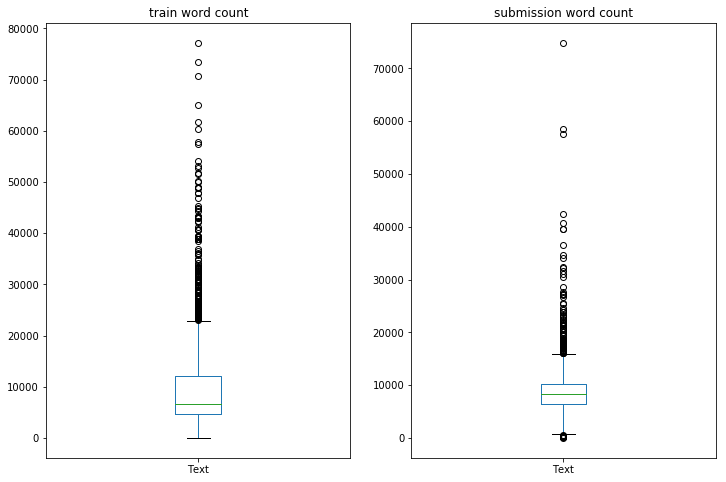

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
train_word_counts.plot.box(ax=axes[0], title='train word count')
submission_word_counts.plot.box(ax=axes[1], title='submission word count')
print(train_word_counts.append(submission_word_counts).describe())

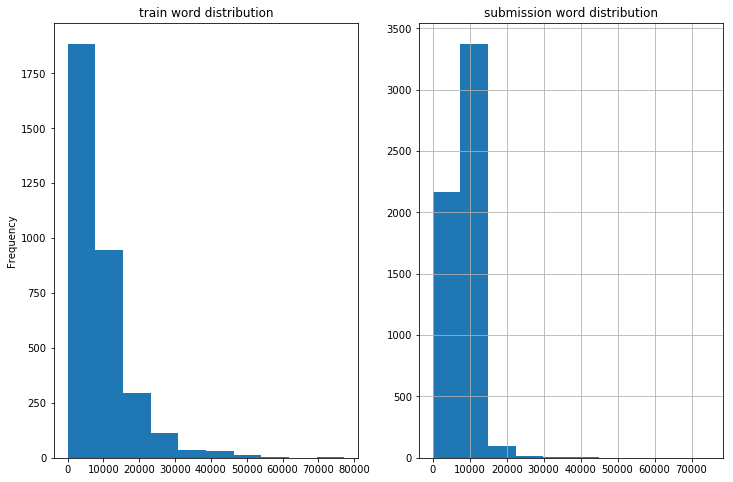

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
train_word_counts.plot.hist(ax=axes[0]).set_title('train word distribution')
submission_word_counts.hist(ax=axes[1]).set_title('submission word distribution')

The text count distribution is **highly skewed right (mean > median)**. The range of the text varies from 1 to 77202, therefore it is not easy to get the key concepts of a text.

### 2.1b Text structure
Because there are some heading in the preview, such as abstract and background, it is worth exploring the structure of a text.

In [10]:
def find_heading_percentage(headings):
    total = 0
    count = 0
    for index, text in tqdm(enumerate(text_column)):
        total += 1
        for word in text.split(' '):
            found = False
            for heading in headings:
                if heading in word: # match partial word e.g (Method vs Methods)
                    found = True
            if found:
                count += 1
                break
    print(100 * count / total, '%')

** abstract, introduction, background **

In [11]:
find_heading_percentage(['Abstract', 'Introduction', 'Background'])

8989it [00:14, 599.90it/s]


69.20680832128157 %


** method, theory **

In [12]:
find_heading_percentage(['Method', 'Theory'])

8989it [00:15, 581.42it/s]


67.68272332851262 %


**result**

In [13]:
find_heading_percentage(['Result'])

8989it [00:13, 660.88it/s]


82.2672154855935 %


**discussion, conclusion, summary**

In [14]:
find_heading_percentage(['Discussion', 'Conclusion', 'Summary'])

8989it [00:17, 518.75it/s]


81.18811881188118 %


It turns out **many Clinical Evidence texts are well structured** and many texts has a section talking about result.

### 2.1c Gene / Variation inside the text?
In this section we will explore if the Clinical Evidence of a sample contains its Gene or Variation features.

**Gene**

In [15]:
training_gene = training_features_df['Gene']
submission_gene = submission_features_df['Gene']
genes = np.append(training_gene, submission_gene)

total = 0
count = 0
for index, text in enumerate(text_column):
    total += 1
    if genes[index] in text:
        count += 1    
print(100 * count / total, '%')

37.73500945600178 %


**Variation**

In [16]:
training_variation = training_features_df['Variation']
submission_variation = submission_features_df['Variation']
variations = np.append(training_variation, submission_variation)

total = 0
count = 0
for index, text in enumerate(text_column):
    total += 1
    if variations[index] in text:
        count += 1
    
print(100 * count / total, '%')

86.6058515963956 %


**Gene or Variation**

In [17]:
total = 0
count = 0
for index, text in enumerate(text_column):
    total += 1
    if genes[index] in text or variations[index] in text:
        count += 1
    
print(100 * count / total, '%')

98.46479029925464 %


**Near all Clinical Evidence contains the Gene or Variation features inside**, It may be useful for shortening the text.

## 2.2 Explore Gene and Variation

### 2.2a Set

In [18]:
genes_set = set(genes)
print(len(genes_set), len(genes))
print(genes_set)

1507 8989
{'TMIE', 'AGXT', 'PCCB', 'NKX2-6', 'NDUFS3', 'GJB4', 'SLC22A18', 'ARID1A', 'FUBP1', 'FREM2', 'BANK1', 'PEX1', 'NPHP1', 'CLCN7', 'EPM2A', 'OTC', 'KLF4', 'TAZ', 'PDHA1', 'ANKH', 'SACS', 'GDNF', 'NLRP7', 'CTSA', 'GAA', 'PDGFRB', 'ALAS2', 'SUMO4', 'PTCH2', 'EYA1', 'DNM1L', 'KDM6A', 'SDHAF1', 'GLA', 'TP63', 'PROM1', 'LPAR6', 'AMACR', 'CACNA1F', 'ARSB', 'ICK', 'POLH', 'LDLRAP1', 'SPG7', 'NT5C3A', 'ASXL1', 'HADH', 'CTRC', 'PHF6', 'CHD7', 'CEBPA', 'PPP6C', 'PLOD2', 'FUCA1', 'SRC', 'UPF3B', 'CYP27B1', 'NR2E3', 'SCNN1G', 'ADAMTSL2', 'OAT', 'ERCC2', 'NBN', 'G6PD', 'ACADM', 'MASTL', 'GALK1', 'ABCC2', 'PHKA1', 'GIF', 'DHCR7', 'FOXP1', 'LPIN2', 'ZNF513', 'EIF2B3', 'FLNA', 'OTOF', 'BCO1', 'KCNMB1', 'GFI1', 'PAFAH1B1', 'ARHGEF9', 'HYLS1', 'ARID2', 'HFE2', 'ITGA2B', 'HSD17B10', 'SETX', 'C2orf71', 'HIST1H1C', 'KLF11', 'RNF135', 'RAD50', 'NIPBL', 'NEK8', 'GYG1', 'GPHN', 'SUFU', 'HSD3B7', 'CTCF', 'CRX', 'ETHE1', 'SIX3', 'ALG12', 'MYOD1', 'CDK12', 'OCRL', 'PRKRA', 'KDR', 'TMEM216', 'RNF6', 'HCRT'

In [19]:
variations_set = set(variations)
print(len(variations_set), len(variations))
print(variations_set)

8609 8989
{'W296R', 'Q238R', 'P120S', 'K507A', 'W255G', 'L46F', 'P2301T', 'R235Q', 'S988A', 'R306S', 'R317W', 'S1709L', 'G52R', 'R265S', 'E75G', 'A115S', 'E164D', 'C600R', 'R76W', 'L70P', 'F81V', 'V205M', 'V353M', 'T17A', 'C96W', 'H145N', 'P156Q', 'T801R', 'A333V', 'R212C', 'V269A', 'V831M', 'C667Y', 'S473L', 'G125V', 'E864K', 'A829P', 'S120R', 'R179T', 'H98R', 'L424V', 'G81D', 'D103G', 'R2973C', 'S562L', 'Y364H', 'L147F', 'I44T', 'C339R', 'R155C', 'V2424G', 'H144P', 'K525E', 'A290T', 'H597Y', 'T148I', 'R262C', 'S227A', 'N219Y', 'S387N', 'I68T', 'S208F', 'F309S', 'D2870A', 'T373K', 'R124L', 'A559T', 'V777M', 'G41R', 'Y572C', 'R970C', 'F125V', 'A125T', 'G555E', 'L232P', 'D191N', 'G1769R', 'R170W', 'G576A', 'G151S', 'G440D', 'C135S', 'V280M', 'G56R', 'R487*', 'V560G', 'S128R', 'Q799E', 'E73V', 'P151A', 'M1652K', 'D1595N', 'D258A', 'C456F', 'L584F', 'G199R', 'D842I', 'E452K', 'H383R', 'C26S', 'W603_E604insDREYEYDLKW', 'R319C', 'V53M', 'A36E', 'G1046R', 'L288S', 'M781I', 'L277P', 'R509H', 

From the above finding, the **one-hot encoding is not applicable for the variation feature**. For genes, the one-hot encoding may be useful.

### 2.2b Correlation between class and gene

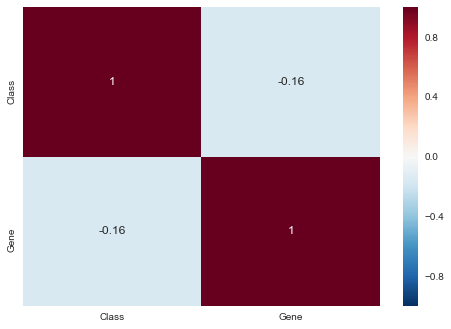

In [186]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
# encode genes to number 
enc = LabelEncoder()
enc.fit(training_gene) 
encoded_genes = enc.transform(training_gene) 
gene_class_df = pd.concat([training_labels, pd.Series(encoded_genes)], axis=1, keys=['Class', 'Gene'])

sns.heatmap(gene_class_df.corr(), annot=True)

The **low correlation** indicates Gene won't help us too much.

In [217]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gene_class_df.drop(['Class'],axis = 1), gene_class_df['Class'], test_size = 0.25, random_state = 0)
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)
print('training acc.', regressor.score(X_train, y_train))
print('testing acc.', regressor.score(X_test, y_test))

training acc. 0.398764389667
testing acc. 0.214169291614


The **low prediction accuracy** also indicates Gene won't help us too much.

### 2.3 Class distribution

In [219]:
training_labels.head()

0    1
1    2
2    2
3    3
4    4
Name: Class, dtype: int64

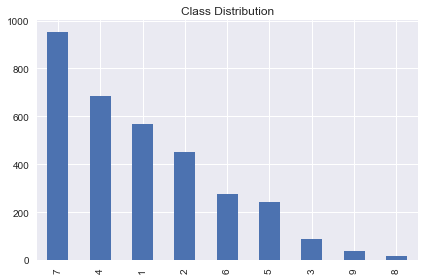

In [220]:
plt.figure()
ax = training_labels.value_counts().plot(kind='bar')
ax.set_title('Class Distribution')
plt.tight_layout()
plt.show()

The **class distribution is not even**, we have to make sure the training dataset contains all classes (e.g. class 8 and 9).

# 3 Summary
1. The text count distribution is highly skewed, some Clinical Evidence text contains many words in it, we may need a way to capture key information. May be the followings help to shorten a text:

    - Many Clinical Evidence texts are well organized in different sections. 

    - Almost all Clinical Evidence texts contain either the sample's Gene or Variation text.

4. The Gene is not really correlated to the Class.

5. Class distribution is also highly skewed, therefore we need to make sure the training set contains all classes.